In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import optimize

from importations.requirement2 import *

# Non Truthful auctions

In [2]:
### Stochastic Bidders: my competitors sample their bids from 
### probability distributions

n_advertisers = 4
n_users = 2000 # to compare with the non-stationary case latter
B = 100
my_valuation = 0.8
rho = B/n_users

# simple scenario: competitors sample bids from a uniform 
other_bids = np.random.uniform(0, 1, size = (n_advertisers-1, n_users))
# I assume that competitors may have a larger budget than mine, but they may
# not deplete it.
m_t = other_bids.max(axis=0)

### the maximum among k uniformly distributed r.v.s is a beta r.v. with alpha=k and beta=1
available_bids = np.linspace(0,1,40)
#win_probabilities = stats.beta.cdf(available_bids, n_advertisers-1, 1)
win_probabilities = np.array([sum(b > m_t)/n_users for b in available_bids])

def compute_clairvoyants_fp_auction(my_valuation, m_t, n_users, available_bids, win_probabilities):
    ## Linear Program
    c = -(my_valuation-available_bids)*win_probabilities
    A_ub = [available_bids*win_probabilities]
    b_ub = [rho]
    A_eq = [np.ones(len(available_bids))]
    b_eq = [1]
    res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1))
    gamma = res.x
    expected_clairvoyant_utilities = [-res.fun for u in range(n_users)]
    expected_clairvoyant_bids = [sum(available_bids*gamma*win_probabilities) for u in range(n_users)]

    return expected_clairvoyant_utilities, expected_clairvoyant_bids

expected_clairvoyant_utilities, expected_clairvoyant_bids = compute_clairvoyants_fp_auction(my_valuation, m_t, n_users, available_bids, win_probabilities)

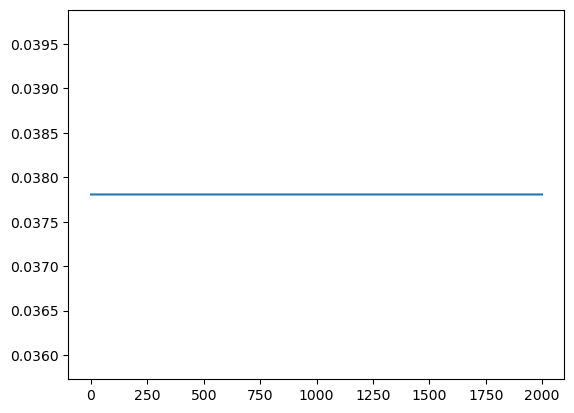

In [3]:
plt.plot(np.arange(n_users), expected_clairvoyant_utilities)

In [4]:
eta = 1/np.sqrt(n_users) # from theory
agent = FFMultiplicativePacingAgent(bids_set = available_bids, 
                                    valuation=my_valuation,
                                    budget=B,
                                    T=n_users, 
                                    eta=eta)

auction = FirstPriceAuction(np.ones(n_advertisers))

utilities_st = np.array([])
my_bids = np.array([])
my_payments_st = np.array([])
clair_payments = np.array([])
total_wins = 0
total_wins_clair = 0

np.random.seed(1)
for u in range(n_users):
    # interaction
    my_bid = agent.bid()
    bids = np.append(my_bid, other_bids[:, u].ravel())
    bids_clair = np.append(expected_clairvoyant_bids[u], other_bids[:, u].ravel())
    winners, payments_per_click = auction.round(bids=bids)
    win_clair, payments_per_click_c = auction.round(bids=bids_clair)
    my_win = int(winners==0)
    clair_win = int(win_clair==0)
    f_t, c_t = (my_valuation-m_t[u])*my_win, m_t[u]*my_win
    f_t_clair, c_t_clair = (my_valuation-m_t[u])*clair_win , m_t[u]*clair_win
    agent.update(f_t, c_t, m_t[u])
    # logging
    utilities_st = np.append(utilities_st, f_t)
    my_bids = np.append(my_bids, my_bid)
    my_payments_st = np.append(my_payments_st, c_t)
    clair_payments = np.append(clair_payments, c_t_clair)
    total_wins+=my_win
    total_wins_clair+= clair_win
print(f'Total # of Wins: {total_wins}')
print(f'Total # of Wins: {total_wins_clair}')

Total # of Wins: 179
Total # of Wins: 0


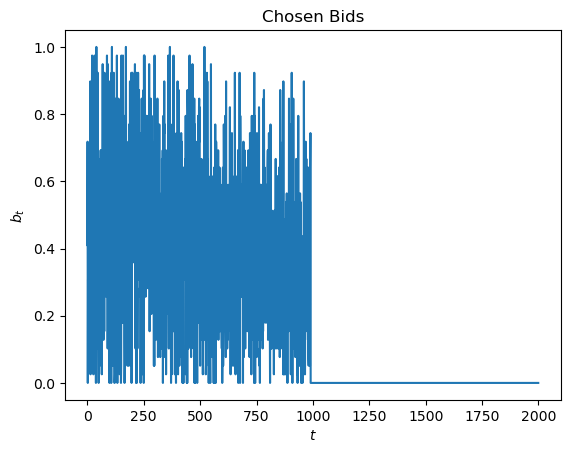

In [5]:
plt.plot(my_bids)
plt.xlabel('$t$')
plt.ylabel('$b_t$')
plt.title('Chosen Bids')
plt.show()

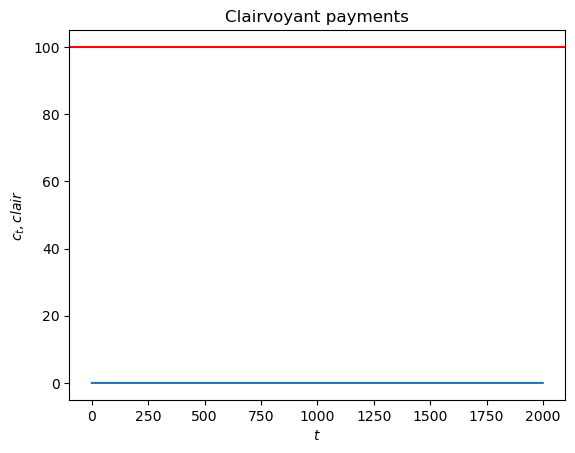

In [6]:
plt.plot(np.cumsum(clair_payments))
plt.xlabel('$t$')
plt.ylabel('$c_t,clair$')
plt.title('Clairvoyant payments')
plt.axhline(B, color='red', label='Budget')
plt.show()

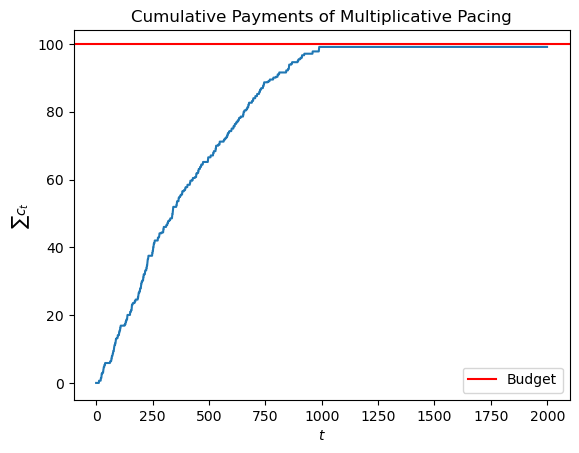

In [7]:
cumulative_payments_st = np.cumsum(my_payments_st)
plt.plot(cumulative_payments_st)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Multiplicative Pacing')
plt.show()

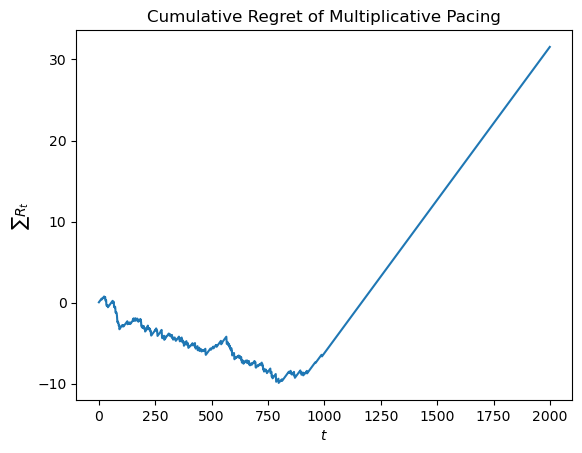

In [8]:
cumulative_regret_st = np.cumsum(expected_clairvoyant_utilities-utilities_st)
plt.plot(cumulative_regret_st)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of Multiplicative Pacing')
plt.show()

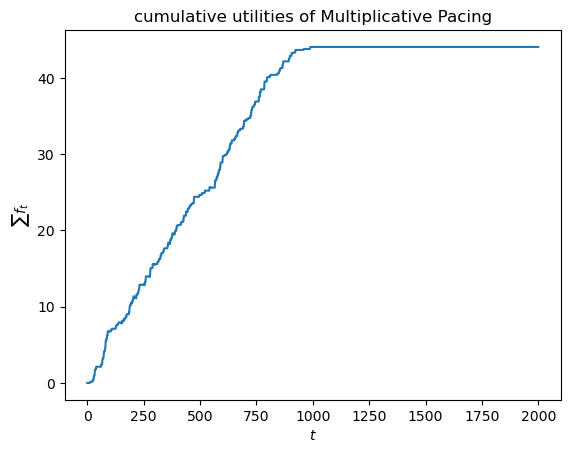

In [9]:
cumulative_utilities_st = np.cumsum(utilities_st)
plt.plot(cumulative_utilities_st)
plt.xlabel('$t$')
plt.ylabel('$\sum f_t$')
plt.title('cumulative utilities of Multiplicative Pacing')
plt.show()

7 280
1960


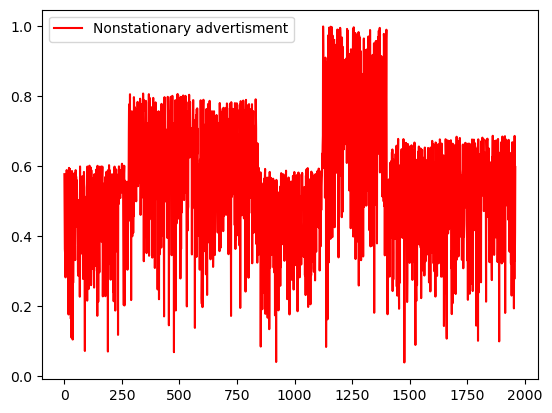

In [10]:
#Creating the noise:
n_users = 280
n_epochs = int(n_users / 40.0) 
print(n_epochs, n_users)
n_advertisers = 4

np.random.seed(42)

def compute_other_bids(n_epochs, n_users, n_advertisers):
    ADV = [] # The list that keeps track of the evolving bids
    for i in range(n_epochs):
        b = np.random.uniform(5,15) # A random coefficient is chosen for a new competing bids distribution
        other_bids = np.random.uniform(0, b*B/n_users, size = ((n_advertisers-1), n_users))
        
        ADV.append(other_bids)

    C = np.hstack(ADV)

    C_min = np.min(C)
    C_max = np.max(C)
    C_normalized = (C - C_min) / (C_max - C_min)

    C = C_normalized

    m_t  =C.max(axis = 0) # The sequence of maximum competing bids

    return m_t, C

m_t, C = compute_other_bids(n_epochs, n_users, n_advertisers)

t = np.arange(n_users*n_epochs)
print(len(m_t))
plt.plot(t,m_t, label = 'Nonstationary advertisment' , color = 'Red')
plt.legend()

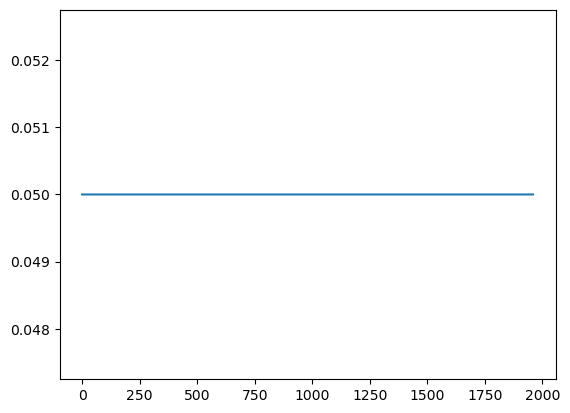

In [11]:
n_users = len(t)

#win_probabilities = stats.beta.cdf(available_bids, n_advertisers-1, 1)
win_probabilities = np.array([sum(b > m_t)/n_users for b in available_bids])

expected_clairvoyant_utilities, expected_clairvoyant_bids = compute_clairvoyants_fp_auction(my_valuation, m_t, n_users, available_bids, win_probabilities)
plt.plot(np.arange(n_users) , expected_clairvoyant_bids)

In [12]:
eta = 1/np.sqrt(n_users) # from theory
agent = FFMultiplicativePacingAgent(bids_set = available_bids, 
                                    valuation=my_valuation,
                                    budget=B,
                                    T=n_users, 
                                    eta=eta)

auction = FirstPriceAuction(np.ones(n_advertisers))

utilities_nst = np.array([])
my_bids = np.array([])
my_payments_nst = np.array([])
total_wins = 0

np.random.seed(1)
for u in range(n_users):
    # interaction
    my_bid = agent.bid()
    bids = np.append(my_bid, C[:, u].ravel())
    winners, payments_per_click = auction.round(bids=bids)
    my_win = int(winners==0)
    f_t, c_t = (my_valuation-m_t[u])*my_win, m_t[u]*my_win
    agent.update(f_t, c_t, m_t[u])
    # logging
    utilities_nst = np.append(utilities_nst, f_t)
    my_bids = np.append(my_bids, my_bid)
    my_payments_nst = np.append(my_payments_nst, c_t)
    total_wins+=my_win
print(f'Total # of Wins: {total_wins}')

Total # of Wins: 223


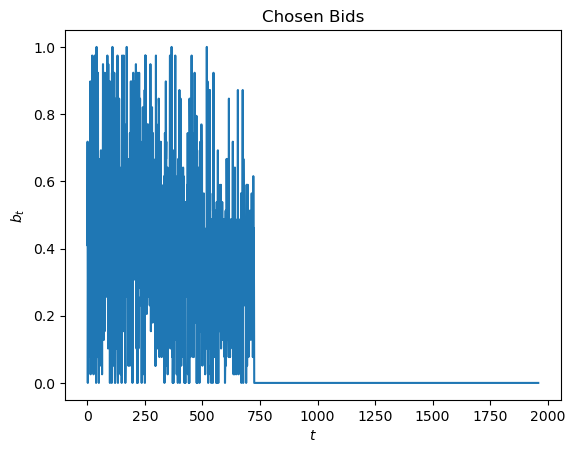

In [13]:
plt.plot(my_bids)
plt.xlabel('$t$')
plt.ylabel('$b_t$')
plt.title('Chosen Bids')
plt.show()

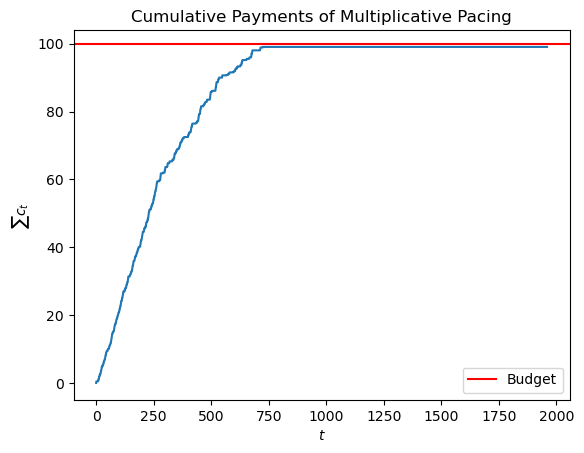

In [14]:
all_payments = np.cumsum(my_payments_nst)

plt.plot(np.arange(n_users), all_payments)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Multiplicative Pacing')
plt.show()

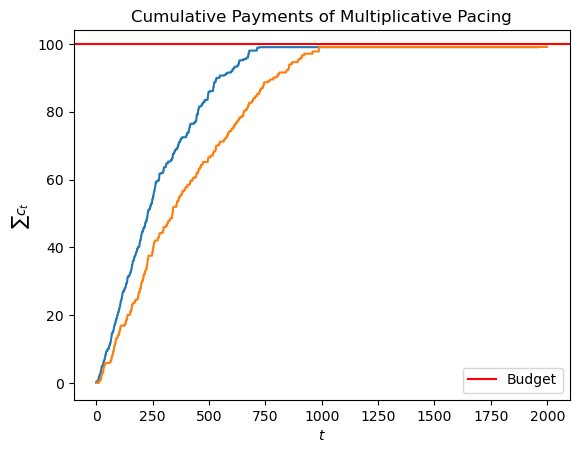

In [15]:
plt.plot(np.arange(n_users), all_payments)
plt.plot(np.arange(2000), cumulative_payments_st)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Multiplicative Pacing')
plt.show()

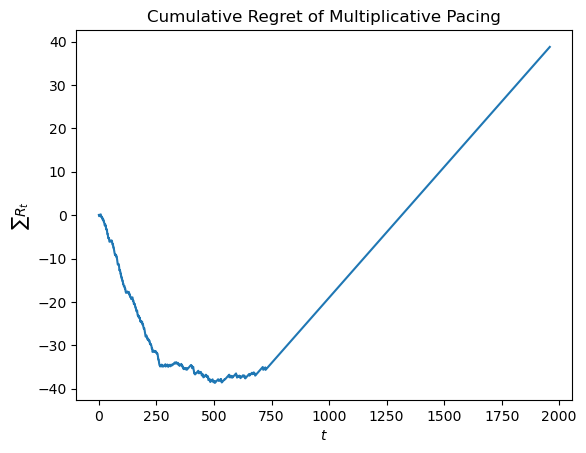

In [16]:
cumulative_regret_nst = np.cumsum(expected_clairvoyant_utilities-utilities_nst)
plt.plot(cumulative_regret_nst)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of Multiplicative Pacing')
plt.show()

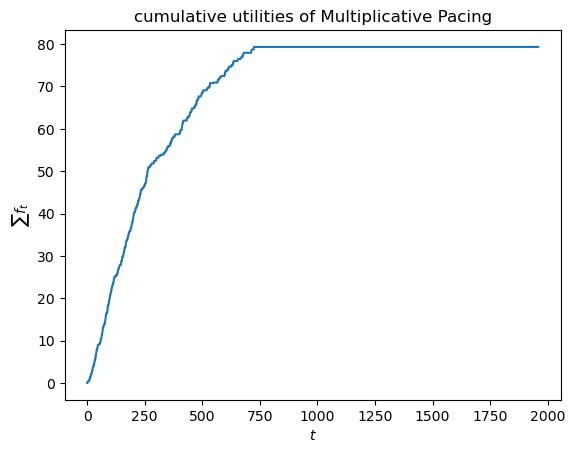

In [17]:
cumulative_utilities = np.cumsum(utilities_nst)
plt.plot(cumulative_utilities)
plt.xlabel('$t$')
plt.ylabel('$\sum f_t$')
plt.title('cumulative utilities of Multiplicative Pacing')
plt.show()

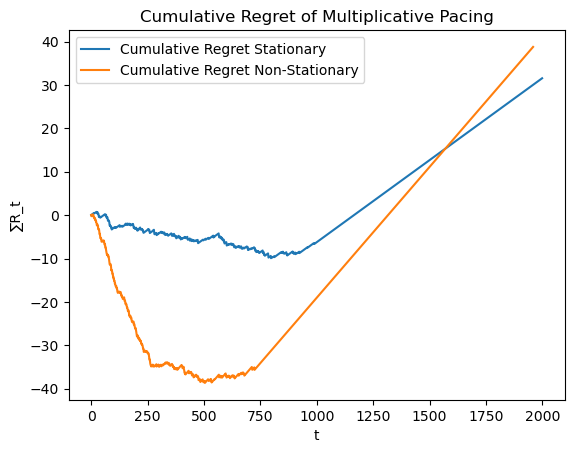

In [18]:
# Plot both on the same graph
plt.plot(cumulative_regret_st, label="Cumulative Regret Stationary")
plt.plot(cumulative_regret_nst, label="Cumulative Regret Non-Stationary")
plt.xlabel('t')
plt.ylabel('∑R_t')
plt.title('Cumulative Regret of Multiplicative Pacing')
plt.legend()
plt.show()

# Pricing (UCB1)

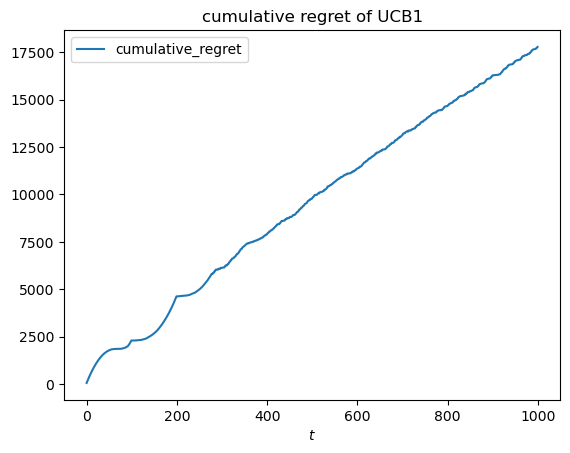

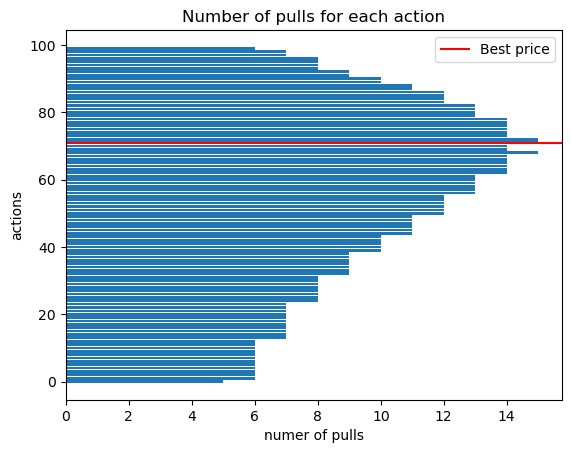

In [19]:
T = 1000 
K = 100

prices = np.linspace(0,1,K) # 100 actions!
cost = 0.1
conversion_probability = lambda p: 1- p**5

n_customers = 100 # I assume the number of customers arriving is the same everyday (for now, in general this is not true)

reward_function = lambda price, n_sales: (price-cost)*n_sales
maximum_profit = reward_function(max(prices), n_customers) # the maximum possible reward is selling at the maximum price to every possible customer

# let's compute the clairvoyant
profit_curve = reward_function(prices, n_customers*conversion_probability(prices))
best_price_index = np.argmax(profit_curve)
best_price = prices[best_price_index]
expected_clairvoyant_rewards = np.repeat(profit_curve[best_price_index], T)

np.random.seed(42)
env = PricingEnvironment(conversion_probability=conversion_probability, cost=cost)
ucb_agent = UCB1Agent(K, T, range=maximum_profit)

agent_rewards = np.array([])

for t in range(T):
    pi_t = ucb_agent.pull_arm() ## the agent returns the index!!
    p_t = prices[pi_t] # I get the actual price
    d_t, r_t = env.round(p_t, n_customers)
    ucb_agent.update(r_t)

    agent_rewards = np.append(agent_rewards, r_t)

cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)



plt.plot(np.arange(T), cumulative_regret, label='cumulative_regret')
plt.title('cumulative regret of UCB1')
plt.xlabel('$t$')
plt.legend()
plt.show()

plt.figure()
plt.barh(np.arange(100), ucb_agent.N_pulls)
plt.axhline(best_price_index, color='red', label='Best price')
plt.ylabel('actions')
plt.xlabel('numer of pulls')
plt.legend()
plt.title('Number of pulls for each action')
plt.show();

# Combining the stationary pricing and the non-truthful auctions

In [20]:
np.random.seed(18)
n_users = 120
n_epochs = int(n_users / 40.0) 
n_advertisers = 4
M = n_users*n_epochs # For each day

agent_rewards = np.array([]) #Here we will store the agent rewards

env = PricingEnvironment(conversion_probability=conversion_probability, cost=cost)
ucb_agent = UCB1Agent(K, T, range=maximum_profit)

for t in range(T):
    pi_t = ucb_agent.pull_arm()  # The agent returns the index
    p_t = prices[pi_t]  # Get the actual price
    my_valuation = p_t

    eta = 1 / np.sqrt(M)  # Learning rate from theory
    
    agent = FFMultiplicativePacingAgent(bids_set = available_bids, 
                                    valuation=my_valuation,
                                    budget=B,
                                    T=n_users, 
                                    eta=eta)

    auction = FirstPriceAuction(np.ones(n_advertisers))

    utilities = np.array([])
    my_bids = np.array([])
    my_payments = np.array([])
    total_wins = 0
    auction_revenue = 0

    
    for u in range(M):
        m_t, C = compute_other_bids(n_epochs, n_users, n_advertisers)

        # Interaction
        my_bid = agent.bid()
        bids = np.append(my_bid, C[:, u].ravel())
        winners, payments_per_click = auction.round(bids=bids)
        my_win = int(winners == 0)
        f_t, c_t = (my_valuation - m_t[u]) * my_win, m_t[u] * my_win
        agent.update(f_t, c_t, m_t[u])
        # Logging
        utilities = np.append(utilities, f_t)
        my_bids = np.append(my_bids, my_bid)
        my_payments = np.append(my_payments, c_t)
        total_wins += my_win


    # Update the pricing environment with the auction results
    d_t, r_t = env.round(p_t, total_wins) #the normalized reward
    Pi_t = r_t - np.sum(my_payments) #The total profit adjusted for auctions costs
    ucb_agent.update(r_t)  # Update the agent with the combined reward

    agent_rewards = np.append(agent_rewards, Pi_t)

    print(f'epoch {t} finished')

cumulative_reward = np.cumsum(agent_rewards)


epoch 0 finished
epoch 1 finished
epoch 2 finished
epoch 3 finished
epoch 4 finished
epoch 5 finished
epoch 6 finished
epoch 7 finished
epoch 8 finished
epoch 9 finished
epoch 10 finished
epoch 11 finished
epoch 12 finished
epoch 13 finished
epoch 14 finished
epoch 15 finished
epoch 16 finished
epoch 17 finished
epoch 18 finished
epoch 19 finished
epoch 20 finished
epoch 21 finished
epoch 22 finished
epoch 23 finished
epoch 24 finished
epoch 25 finished
epoch 26 finished
epoch 27 finished
epoch 28 finished
epoch 29 finished
epoch 30 finished
epoch 31 finished
epoch 32 finished
epoch 33 finished
epoch 34 finished
epoch 35 finished
epoch 36 finished
epoch 37 finished
epoch 38 finished
epoch 39 finished
epoch 40 finished
epoch 41 finished
epoch 42 finished
epoch 43 finished
epoch 44 finished
epoch 45 finished
epoch 46 finished
epoch 47 finished
epoch 48 finished
epoch 49 finished
epoch 50 finished
epoch 51 finished
epoch 52 finished
epoch 53 finished
epoch 54 finished
epoch 55 finished
ep

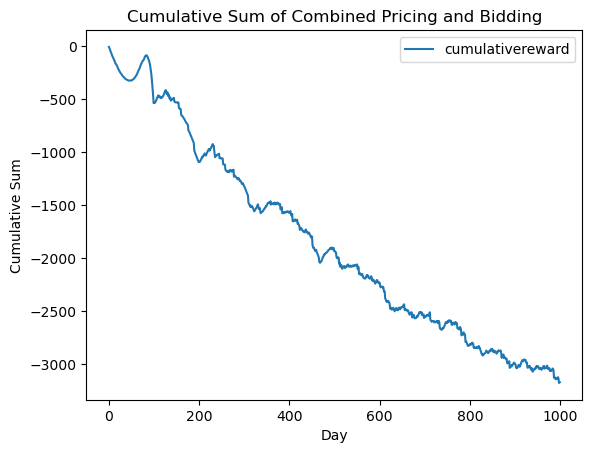

In [21]:
# Plotting results
plt.plot(np.arange(T), cumulative_reward, label='cumulativereward')
plt.title('Cumulative Sum of Combined Pricing and Bidding')
plt.xlabel('Day')
plt.ylabel('Cumulative Sum')
plt.legend()
plt.show()

The pricing environment is non-stationary, with a demand curve evolving over-time.

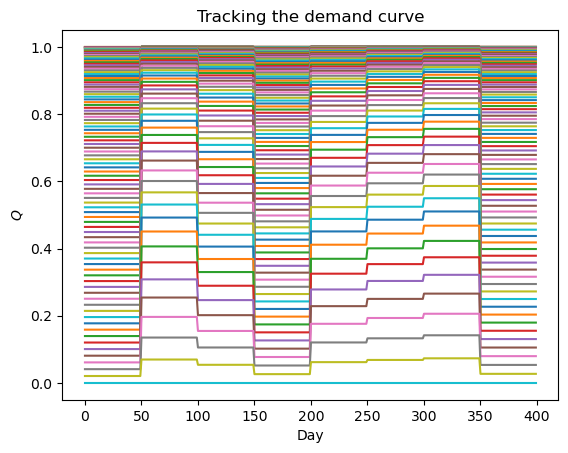

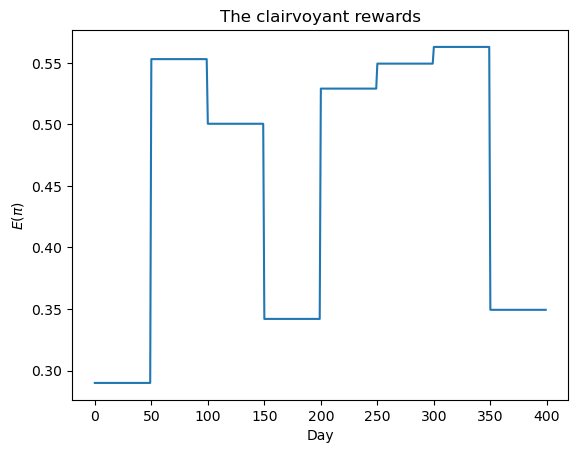

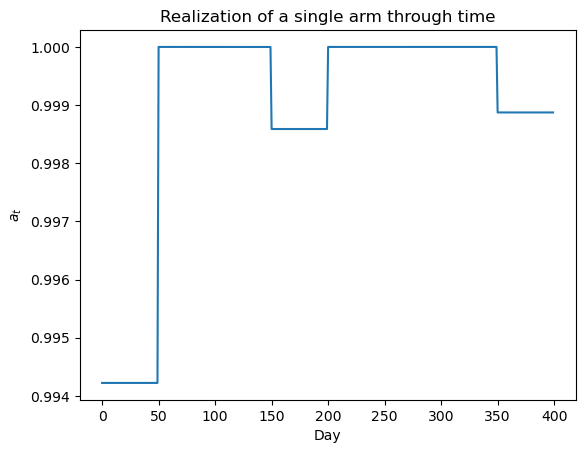

In [22]:
D = 100
prices = np.linspace(0,1,D)
mu = []
ru = [] # The rewards in expectation
n_epochs_pricing = 20
m = 1000
cp = int(m/n_epochs_pricing)
for t in range(n_epochs_pricing):
    b = np.random.uniform(2,8) # A random coefficient is chosen for a new demand curve
    conversion_probability = lambda p: 1- p**b
    y_obs = np.array([])
    y2_obs = np.array([])
    for j in range(0,K):
       new_y_obs = conversion_probability(prices[j]) 
       new_y2_obs = conversion_probability(prices[j])*prices[j] - cost
       y_obs = np.append(y_obs,new_y_obs)
       y2_obs = np.append(y2_obs, new_y2_obs)
    mu.append(y_obs)
    ru.append(y2_obs)
A = ([mu[0]]*cp+ [mu[1]]*cp + [mu[2]]*cp + [mu[3]]*cp + [mu[4]]*cp + [mu[5]]*cp +[mu[6]]*cp + [mu[7]]*cp  )
U = ([ru[0]]*cp+ [ru[1]]*cp + [ru[2]]*cp + [ru[3]]*cp + [ru[4]]*cp + [ru[5]]*cp +[ru[6]]*cp + [ru[7]]*cp ) 
F = ([mu[0][8]]*cp+ [mu[1][8]]*cp + [mu[2][8]]*cp + [mu[3][8]]*cp + [mu[4][8]]*cp + [mu[5][8]]*cp +[mu[6][8]]*cp + [mu[7][8]]*cp  )
T = len(A)
expected_clairvoyant_profits = np.array(U).max(axis=1)
plt.plot(np.arange(T), A)
plt.title('Tracking the demand curve')
plt.xlabel('Day')
plt.ylabel('$Q$')
plt.show()


plt.plot(np.arange(T), expected_clairvoyant_profits)
plt.title('The clairvoyant rewards')
plt.xlabel('Day')
plt.ylabel('$E(\pi)$')
plt.show()

plt.plot(np.arange(T), F)
plt.title('Realization of a single arm through time')
plt.xlabel('Day')
plt.ylabel('$a_t$')
plt.show()


Non-stationary combined environment:

epoch 0 finished
epoch 1 finished
epoch 2 finished
epoch 3 finished
epoch 4 finished
epoch 5 finished
epoch 6 finished
epoch 7 finished
epoch 8 finished
epoch 9 finished
epoch 10 finished
epoch 11 finished
epoch 12 finished
epoch 13 finished
epoch 14 finished
epoch 15 finished
epoch 16 finished
epoch 17 finished
epoch 18 finished
epoch 19 finished
epoch 20 finished
epoch 21 finished
epoch 22 finished
epoch 23 finished
epoch 24 finished
epoch 25 finished
epoch 26 finished
epoch 27 finished
epoch 28 finished
epoch 29 finished
epoch 30 finished
epoch 31 finished
epoch 32 finished
epoch 33 finished
epoch 34 finished
epoch 35 finished
epoch 36 finished
epoch 37 finished
epoch 38 finished
epoch 39 finished
epoch 40 finished
epoch 41 finished
epoch 42 finished
epoch 43 finished
epoch 44 finished
epoch 45 finished
epoch 46 finished
epoch 47 finished
epoch 48 finished
epoch 49 finished
epoch 50 finished
epoch 51 finished
epoch 52 finished
epoch 53 finished
epoch 54 finished
epoch 55 finished
ep

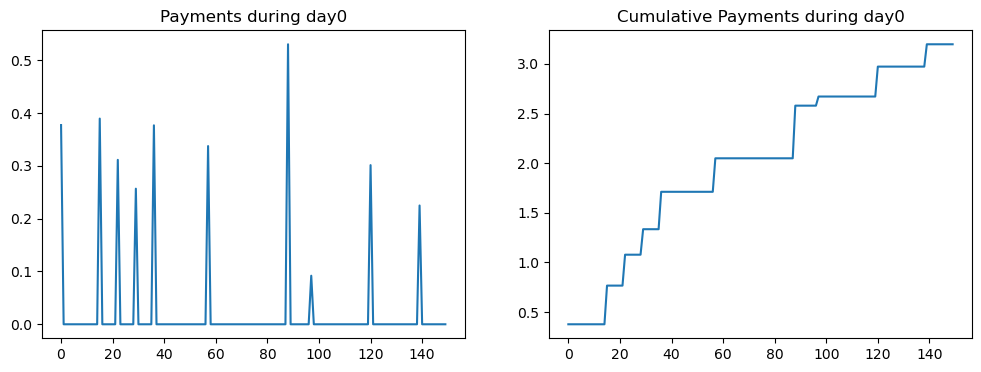

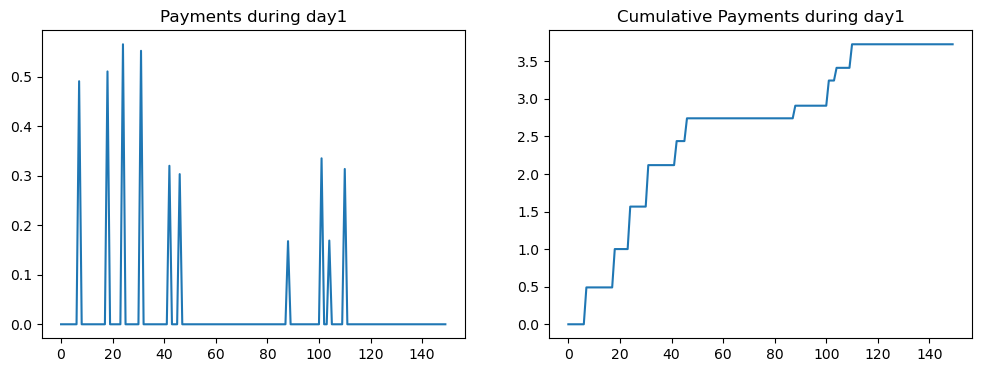

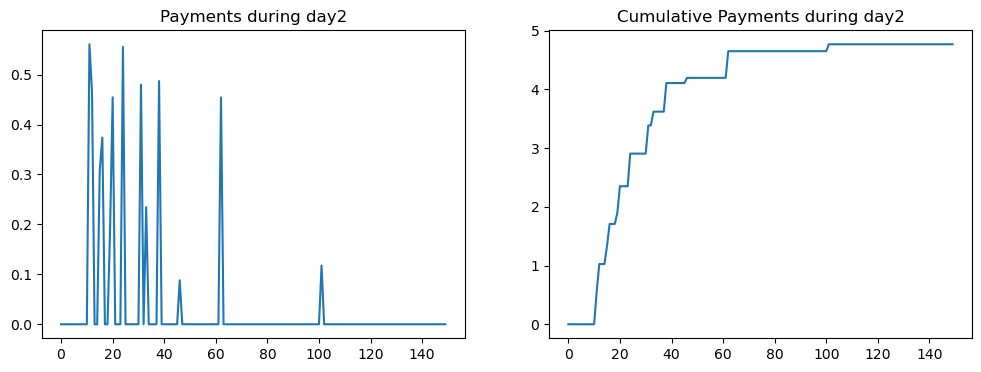

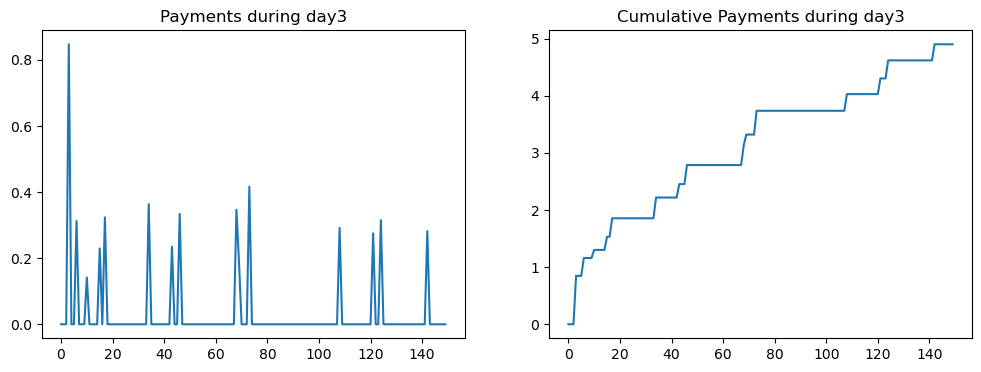

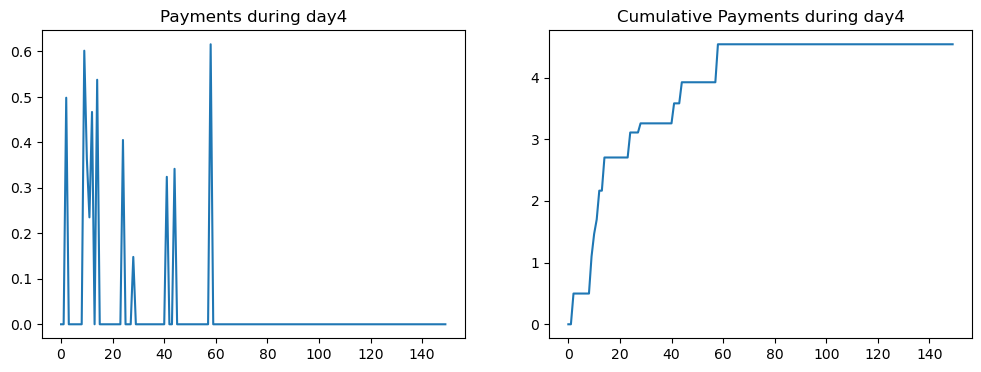

In [23]:
np.random.seed(18)
B = 100
n_users = 50
M = n_users*n_epochs # For each day

agent_rewards = np.array([]) #Here we will store the agent rewards

env = NonstationaryPricingEnv(A,prices, cost, T, np.random.seed(18))
ucb_agent = UCB1Agent(K, T, range=maximum_profit)
expected_clairvoyant_profits_adj = np.array([])
w = 0
for t in range(T):
    pi_t = ucb_agent.pull_arm()  # The agent returns the index
    p_t = prices[pi_t]  # Get the actual price
    my_valuation = p_t

    eta = 1 / np.sqrt(M)  # Learning rate from theory
    
    agent = FFMultiplicativePacingAgent(bids_set = available_bids, 
                                    valuation=my_valuation,
                                    budget=B,
                                    T=n_users, 
                                    eta=eta)

    auction = FirstPriceAuction(np.ones(n_advertisers))

    utilities = np.array([])
    my_bids = np.array([])
    my_payments = np.array([])
    total_wins = 0
    auction_revenue = 0
    total_wins_clair = 0
    

    
    for u in range(M):
        m_t, C = compute_other_bids(n_epochs, n_users, n_advertisers)

        # Interaction
        my_bid = agent.bid()
        bids = np.append(my_bid, C[:, u].ravel())
        bids_clair = np.append(expected_clairvoyant_bids[u], other_bids[:, u].ravel())
        winners, payments_per_click = auction.round(bids=bids)
        win_clair, payments_per_click_c = auction.round(bids=bids_clair)
        my_win = int(winners == 0)
        f_t, c_t = (my_valuation - m_t[u]) * my_win, m_t[u] * my_win
        f_t_clair, c_t_clair = (my_valuation-m_t[u])*clair_win , m_t[u]*clair_win
        agent.update(f_t, c_t, m_t[u])
        # Logging
        utilities = np.append(utilities, f_t)
        my_bids = np.append(my_bids, my_bid)
        my_payments = np.append(my_payments, c_t)
        clair_payments = np.append(clair_payments, c_t_clair)
        total_wins += my_win
        total_wins_clair+= clair_win

    if w <= 4:
        fig, axs = plt.subplots(1, 2, figsize=(12, 4))
        axs[0].plot(np.arange(M), my_payments)
        axs[0].set_title('Payments during day' f'{w}')
        axs[1].plot(np.arange(M), np.cumsum(my_payments))
        axs[1].set_title('Cumulative Payments during day' f'{w}')
        
    w += 1        

    expected_clairvoyant_profits_adj_i = expected_clairvoyant_profits[t]*total_wins_clair - np.sum(clair_payments)
    expected_clairvoyant_profits_adj = np.append(expected_clairvoyant_profits_adj,expected_clairvoyant_profits_adj_i)
    # Update the pricing environment with the auction results
    r_t = env.round(pi_t) * total_wins #the reward accounting for the number of customers
    Pi_t = r_t - np.sum(my_payments) #The total profit adjusted for auctions costs
    ucb_agent.update(r_t)  # Update the agent with the combined reward

    agent_rewards = np.append(agent_rewards, Pi_t)

    print(f'epoch {t} finished')

cumulative_reward = np.cumsum(agent_rewards)

Text(0.5, 1.0, 'Regret per round for the agent')

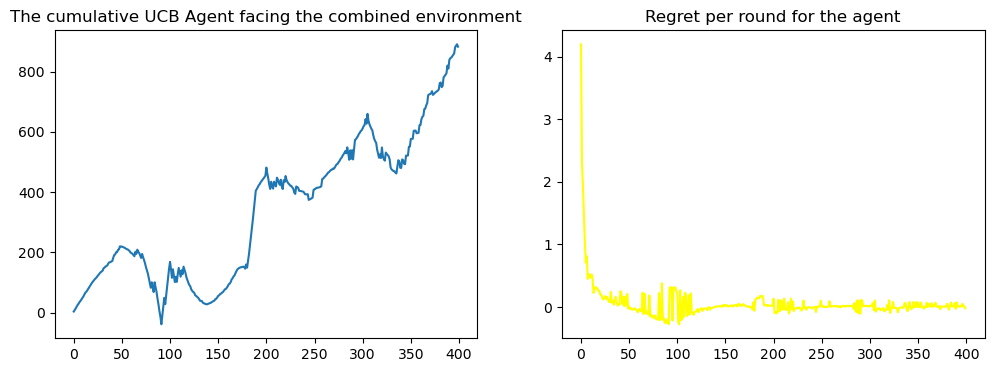

In [24]:
cumulative_regret_nst_com = np.cumsum(expected_clairvoyant_profits_adj - agent_rewards)
regret_nst_com = expected_clairvoyant_profits_adj - agent_rewards
t = range(1, T + 1)
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(np.arange(T), cumulative_regret_nst_com, label= 'cumulative regret of combined agent')
axs[0].set_title('The cumulative UCB Agent facing the combined environment')
axs[1].plot(np.arange(T), regret_nst_com/np.array(t) , label = 'Regret per round', color= 'yellow')
axs[1].set_title('Regret per round for the agent')